# Combine Odds Data
Combine betting odds data to get a feel for how 'profitable' the model is, explore different betting strategies.

## Reloading previous model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
nba_games = pd.read_csv('data/03_improved_model.csv')
nba_games["GAME_DATE_EST"] = pd.to_datetime(nba_games["GAME_DATE_EST"])
nba_games["GAME_DATE_STR"] = pd.to_datetime(nba_games["GAME_DATE_EST"]).dt.strftime('%Y-%m-%d')
nba_games.head()


,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,AWAY_TEAM_ID,SEASON,HOME_TEAM_POINTS,AWAY_TEAM_POINTS,HOME_WIN_PCT,HOME_HOME_WIN_PCT,AWAY_WIN_PCT,AWAY_AWAY_WIN_PCT,HOME_TEAM_WINS,HOME_TEAM_B2B,AWAY_TEAM_B2B,GAME_DATETIME,HOME_LAST_10_WIN_PCT,AWAY_LAST_10_WIN_PCT,GAME_DATE_STR
0,2017-10-17,21700001.0,1.610613e+09,1.610613e+09,2017.0,102.0,99.0,1.0,1.0,0.0,0.0,True,False,False,1.508198e+18,0.6,0.7,2017-10-17
1,2017-10-17,21700002.0,1.610613e+09,1.610613e+09,2017.0,121.0,122.0,0.0,0.0,1.0,1.0,False,False,False,1.508198e+18,0.7,0.7,2017-10-17
2,2017-10-18,21700003.0,1.610613e+09,1.610613e+09,2017.0,102.0,90.0,1.0,1.0,0.0,0.0,True,False,False,1.508285e+18,0.5,0.3,2017-10-18
3,2017-10-18,21700004.0,1.610613e+09,1.610613e+09,2017.0,140.0,131.0,1.0,1.0,0.0,0.0,True,False,False,1.508285e+18,0.7,0.4,2017-10-18
4,2017-10-18,21700006.0,1.610613e+09,1.610613e+09,2017.0,120.0,115.0,1.0,1.0,0.0,0.0,True,False,False,1.508285e+18,0.7,0.6,2017-10-18


## Merge canonical team data with moneyline odds

In [3]:
teams = pd.read_csv('data/raw/nba_teams.csv')
teams.head()

,LEAGUE_ID,TEAM_ID,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612766,CHA,Hornets,1988,Charlotte,Spectrum Center,19026.0,Rick Schnall,Mitch Kupchak,Charles Lee,Greensboro Swarm
1,0,1610612765,DET,Pistons,1948,Detroit,Little Caesars Arena,NaN,Tom Gores,Ed Stefanski,J. B. Bickerstaff,Motor City Cruise
2,0,1610612764,WAS,Wizards,1961,Washington,Capital One Arena,20647.0,Ted Leonsis,Tommy Sheppard,Brian Keefe,Capital City Go-Go
3,0,1610612763,MEM,Grizzlies,1995,Memphis,FedExForum,18119.0,Robert Pera,Zach Kleiman,Taylor Jenkins,Memphis Hustle
4,0,1610612762,UTA,Jazz,1974,Utah,Delta Center,NaN,Ryan Smith,Justin Zanik,Will Hardy,Salt Lake City Stars


In [4]:
moneylines = pd.read_csv('data/raw/odds/moneyline.csv')
moneylines.head()

,date,away,home,fanduel_away_odds,fanduel_home_odds,mgm_away_odds,mgm_home_odds,draftkings_away_odds,draftkings_home_odds,caesars_away_odds,caesars_home_odds
0,2019-10-22,New Orleans,Toronto,800.0,-1800.0,230.0,-294.0,1500.0,-5000.0,245.0,-290.0
1,2019-10-22,L.A. Lakers,L.A. Clippers,750.0,-1600.0,-167.0,140.0,1150.0,-2500.0,NaN,NaN
2,2019-10-23,Chicago,Charlotte,120.0,-145.0,-133.0,110.0,132.0,-175.0,-160.0,140.0
3,2019-10-23,Detroit,Indiana,-2400.0,1200.0,145.0,-175.0,-150.0,115.0,250.0,-300.0
4,2019-10-23,Cleveland,Orlando,3300.0,-8000.0,260.0,-323.0,420.0,-670.0,375.0,-475.0


In [5]:
def translate_city(city):
  if city.startswith("L.A."):
    nickname = city.split(" ")[1]
    team = teams[teams["NICKNAME"] == nickname]
    return team["TEAM_ID"].values[0]
  else:
    team = teams[teams["CITY"] == city]
    return team["TEAM_ID"].values[0]

moneylines["AWAY_TEAM_ID"] = moneylines["away"].apply(translate_city)
moneylines["HOME_TEAM_ID"] = moneylines["home"].apply(translate_city)
moneylines.columns = [c.upper() for c in moneylines.columns]
moneylines = moneylines.drop(columns=["AWAY", "HOME"])
moneylines.head()

,DATE,FANDUEL_AWAY_ODDS,FANDUEL_HOME_ODDS,MGM_AWAY_ODDS,MGM_HOME_ODDS,DRAFTKINGS_AWAY_ODDS,DRAFTKINGS_HOME_ODDS,CAESARS_AWAY_ODDS,CAESARS_HOME_ODDS,AWAY_TEAM_ID,HOME_TEAM_ID
0,2019-10-22,800.0,-1800.0,230.0,-294.0,1500.0,-5000.0,245.0,-290.0,1610612740,1610612761
1,2019-10-22,750.0,-1600.0,-167.0,140.0,1150.0,-2500.0,NaN,NaN,1610612747,1610612746
2,2019-10-23,120.0,-145.0,-133.0,110.0,132.0,-175.0,-160.0,140.0,1610612741,1610612766
3,2019-10-23,-2400.0,1200.0,145.0,-175.0,-150.0,115.0,250.0,-300.0,1610612765,1610612754
4,2019-10-23,3300.0,-8000.0,260.0,-323.0,420.0,-670.0,375.0,-475.0,1610612739,1610612753


## Combine moneyline data with game data

In [6]:
moneylines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6180 entries, 0 to 6179
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  6180 non-null   object 
 1   FANDUEL_AWAY_ODDS     6134 non-null   float64
 2   FANDUEL_HOME_ODDS     6134 non-null   float64
 3   MGM_AWAY_ODDS         4393 non-null   float64
 4   MGM_HOME_ODDS         4393 non-null   float64
 5   DRAFTKINGS_AWAY_ODDS  6134 non-null   float64
 6   DRAFTKINGS_HOME_ODDS  6134 non-null   float64
 7   CAESARS_AWAY_ODDS     5788 non-null   float64
 8   CAESARS_HOME_ODDS     5788 non-null   float64
 9   AWAY_TEAM_ID          6180 non-null   int64  
 10  HOME_TEAM_ID          6180 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 531.2+ KB


In [7]:
nba_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8595 entries, 0 to 8594
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   GAME_DATE_EST         8593 non-null   datetime64[ns]
 1   GAME_ID               8593 non-null   float64       
 2   HOME_TEAM_ID          8593 non-null   float64       
 3   AWAY_TEAM_ID          8593 non-null   float64       
 4   SEASON                8593 non-null   float64       
 5   HOME_TEAM_POINTS      8593 non-null   float64       
 6   AWAY_TEAM_POINTS      8593 non-null   float64       
 7   HOME_WIN_PCT          8593 non-null   float64       
 8   HOME_HOME_WIN_PCT     8593 non-null   float64       
 9   AWAY_WIN_PCT          8593 non-null   float64       
 10  AWAY_AWAY_WIN_PCT     8593 non-null   float64       
 11  HOME_TEAM_WINS        8595 non-null   bool          
 12  HOME_TEAM_B2B         8593 non-null   object        
 13  AWAY_TEAM_B2B     

In [8]:
nba_games_with_moneylines = nba_games.merge(moneylines, left_on=["GAME_DATE_STR", "HOME_TEAM_ID", "AWAY_TEAM_ID"], right_on=["DATE", "HOME_TEAM_ID", "AWAY_TEAM_ID"])
nba_games_with_moneylines.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,AWAY_TEAM_ID,SEASON,HOME_TEAM_POINTS,AWAY_TEAM_POINTS,HOME_WIN_PCT,HOME_HOME_WIN_PCT,AWAY_WIN_PCT,...,GAME_DATE_STR,DATE,FANDUEL_AWAY_ODDS,FANDUEL_HOME_ODDS,MGM_AWAY_ODDS,MGM_HOME_ODDS,DRAFTKINGS_AWAY_ODDS,DRAFTKINGS_HOME_ODDS,CAESARS_AWAY_ODDS,CAESARS_HOME_ODDS
0,2019-10-22,21900001.0,1.610613e+09,1.610613e+09,2019.0,130.0,122.0,1.0,1.0,0.0,...,2019-10-22,2019-10-22,800.0,-1800.0,230.0,-294.0,1500.0,-5000.0,245.0,-290.0
1,2019-10-22,21900002.0,1.610613e+09,1.610613e+09,2019.0,112.0,102.0,1.0,1.0,0.0,...,2019-10-22,2019-10-22,750.0,-1600.0,-167.0,140.0,1150.0,-2500.0,NaN,NaN
2,2019-10-23,21900003.0,1.610613e+09,1.610613e+09,2019.0,126.0,125.0,1.0,1.0,0.0,...,2019-10-23,2019-10-23,120.0,-145.0,-133.0,110.0,132.0,-175.0,-160.0,140.0
3,2019-10-23,21900004.0,1.610613e+09,1.610613e+09,2019.0,110.0,119.0,0.0,0.0,1.0,...,2019-10-23,2019-10-23,-2400.0,1200.0,145.0,-175.0,-150.0,115.0,250.0,-300.0
4,2019-10-23,21900007.0,1.610613e+09,1.610613e+09,2019.0,120.0,101.0,1.0,1.0,0.0,...,2019-10-23,2019-10-23,280.0,-370.0,285.0,-400.0,600.0,-1250.0,225.0,-265.0


### Use odds data to calculate profitability on test sets of data
Will use prediction vs actual result to determine winnings for each game

In [9]:
feat_cols = [
  "GAME_DATETIME",
  "HOME_TEAM_ID",
  "AWAY_TEAM_ID",
  "HOME_WIN_PCT",
  "HOME_HOME_WIN_PCT",
  "AWAY_WIN_PCT",
  "AWAY_AWAY_WIN_PCT",
  "HOME_TEAM_B2B",
  "AWAY_TEAM_B2B",
  "HOME_LAST_10_WIN_PCT",
  "AWAY_LAST_10_WIN_PCT"
]

target = "HOME_TEAM_WINS"

In [10]:
def apply_win_odds(row, wager=10.0):
  if row["PREDICTION"] == 1 and row["HOME_TEAM_WINS"] == 1: # Correct home predictions
    home_odds = row["FANDUEL_HOME_ODDS"] or row["BETMGM_HOME_ODDS"] or row["CAESARS_HOME_ODDS"] or row["DRAFKINGS_HOME_ODDS"]
    if home_odds is None:
      return 0
    if home_odds < 0:
      return wager * (100 / abs(home_odds))
    else:
      return wager * (home_odds / 100)
  elif row["PREDICTION"] == 0 and row["HOME_TEAM_WINS"] == 0: # Correct away predictions
    away_odds = row["FANDUEL_AWAY_ODDS"] or row["BETMGM_AWAY_ODDS"] or row["CAESARS_AWAY_ODDS"] or row["DRAFKINGS_AWAY_ODDS"]
    if away_odds is None:
      return 0
    if away_odds < 0:
      return wager * (100 / abs(away_odds))
    else:
      return wager * (away_odds / 100)
  else: # Incorrect predictions
    return -wager

def calculate_season_profitability(s):
  season = nba_games_with_moneylines.loc[(nba_games_with_moneylines['SEASON'] == s)].sort_values(by="GAME_DATETIME")
  train_1, test_1, test_2 = np.array_split(season, 3)
  train = pd.concat([train_1])
  X_train, y_train = train[feat_cols], train[target]

  test = pd.concat([test_1, test_2])
  X_test, y_test = test[feat_cols], test[target]
  clf = RandomForestClassifier(random_state=42, n_jobs=2, n_estimators=1000, max_depth=7, bootstrap=True)
  clf.fit(X_train, y_train)
  print('Train accuracy:',clf.score(X_train, y_train))
  print('Test accuracy:', clf.score(X_test, y_test))

  test["PREDICTION"] = clf.predict(X_test)
  test["PROFIT"] = test.apply(apply_win_odds, axis=1)
  profit = test["PROFIT"].sum()

  plt.plot(test["GAME_DATE_EST"].unique(), test.groupby("GAME_DATE_EST")["PROFIT"].sum().cumsum())
  ax = plt.gca()
  ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
  plt.locator_params(axis='x', nbins=5)
  plt.show()
  return (profit, len(test), profit / (len(test) * 10))

/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9560975609756097
Test accuracy: 0.7451219512195122


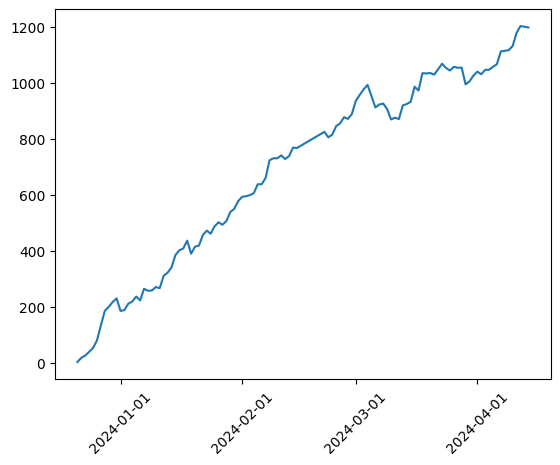

(np.float64(1196.8872507088217), 820, np.float64(0.14596185984253923))

In [11]:
calculate_season_profitability(2023)

## Initial season by season profitability
Starting bets in Jan of the NBA season results in pretty strong results.

******* CALCULATING SEASON **********
2020


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.975
Test accuracy: 0.7319444444444444


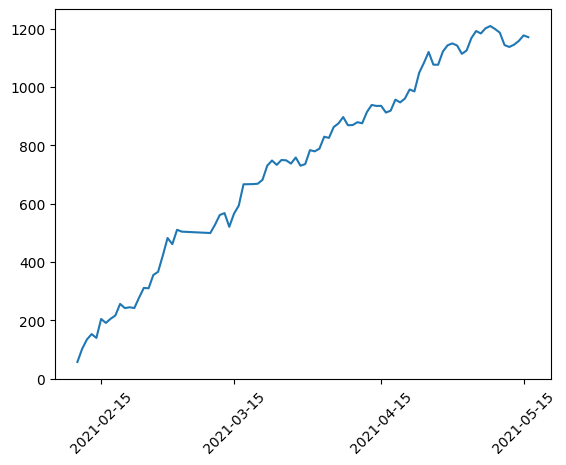

Profit: 1171.0712977427106
Total Wagered: 7200
Profitability: 0.16264879135315424
******* CALCULATING SEASON **********
2021


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9512195121951219
Test accuracy: 0.725609756097561


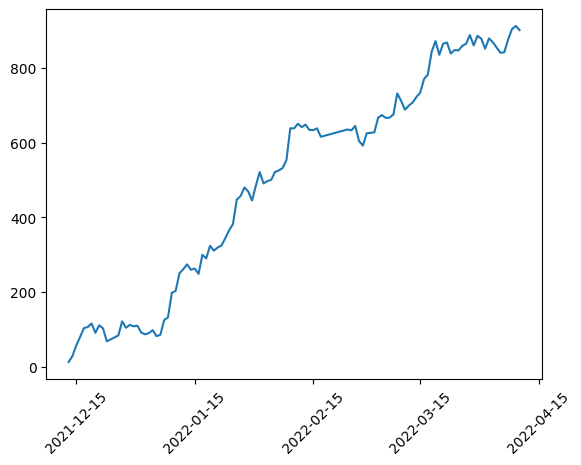

Profit: 901.3480758861347
Total Wagered: 8200
Profitability: 0.10992049705928472
******* CALCULATING SEASON **********
2022


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9391727493917275
Test accuracy: 0.6853658536585366


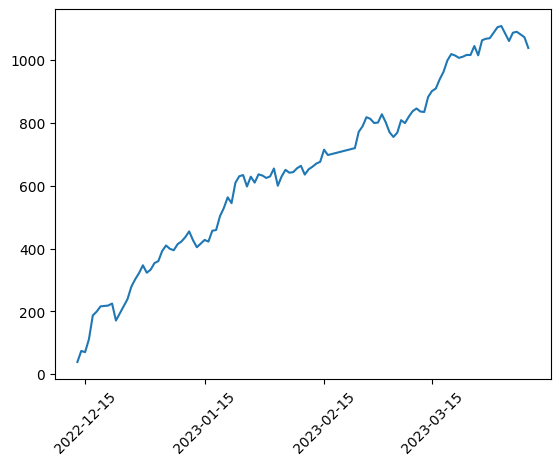

Profit: 1038.9772941377519
Total Wagered: 8200
Profitability: 0.1267045480655795
******* CALCULATING SEASON **********
2023


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 0.9560975609756097
Test accuracy: 0.7451219512195122


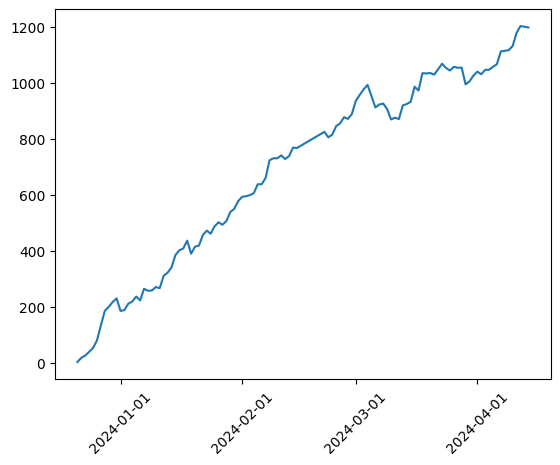

Profit: 1196.8872507088217
Total Wagered: 8200
Profitability: 0.14596185984253923
******* CALCULATING SEASON **********
2024


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Train accuracy: 1.0
Test accuracy: 0.7475247524752475


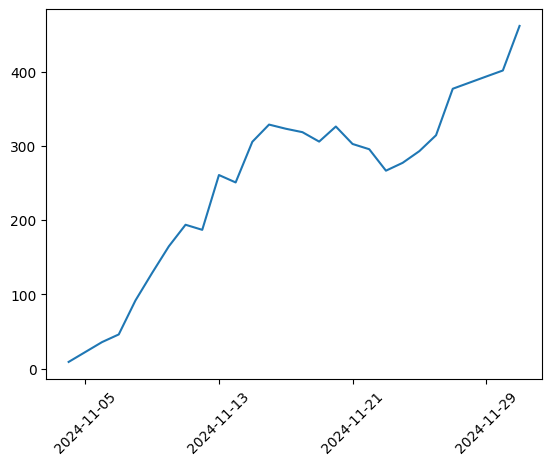

Profit: 461.72746194218144
Total Wagered: 2020
Profitability: 0.22857795145652546


In [12]:
for i in range(2020, 2025):
  print("******* CALCULATING SEASON **********")
  print(i)
  profit, total_wagers, profitability = calculate_season_profitability(i)
  print(f"Profit: {profit}")
  print(f"Total Wagered: {total_wagers * 10 }")
  print(f"Profitability: {profitability}")

In [13]:
nba_games_with_moneylines.to_csv('data/04_improved_model_with_moneylines.csv', index=False)

## Comparing results with just wagering on the moneyline favorite

In [14]:
def apply_moneyline_win_odds(row, wager=10.0):
  home_odds = row["FANDUEL_HOME_ODDS"] or row["BETMGM_HOME_ODDS"] or row["CAESARS_HOME_ODDS"] or row["DRAFKINGS_HOME_ODDS"]
  away_odds = row["FANDUEL_AWAY_ODDS"] or row["BETMGM_AWAY_ODDS"] or row["CAESARS_AWAY_ODDS"] or row["DRAFKINGS_AWAY_ODDS"]
  if home_odds is None:
    return 0
  elif home_odds < 0 and row["HOME_TEAM_WINS"] == 1: # Correct home predictions
    return wager * (100 / abs(home_odds))
  elif away_odds is None:
    return 0
  elif away_odds < 0 and row["HOME_TEAM_WINS"] == 0: # Correct away predictions
    return wager * (100 / abs(away_odds))
  else: # Incorrect predictions
    return -wager

def calculate_moneyline_season_profitability(s):
  season = nba_games_with_moneylines.loc[(nba_games_with_moneylines['SEASON'] == s)].sort_values(by="GAME_DATETIME")
  _, test_1, test_2 = np.array_split(season, 3)

  test = pd.concat([test_1, test_2])

  test["PROFIT"] = test.apply(apply_moneyline_win_odds, axis=1)
  profit = test["PROFIT"].sum()

  plt.plot(test["GAME_DATE_EST"].unique(), test.groupby("GAME_DATE_EST")["PROFIT"].sum().cumsum())
  ax = plt.gca()
  ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
  plt.locator_params(axis='x', nbins=5)
  plt.show()
  return (profit, len(test), profit / (len(test) * 10))

******* CALCULATING SEASON **********
2020


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


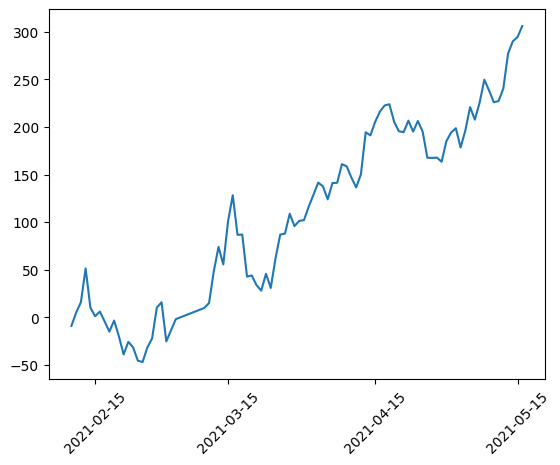

Profit: 305.97366922128197
Total Wagered: 7200
Profitability: 0.042496342947400276
******* CALCULATING SEASON **********
2021


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


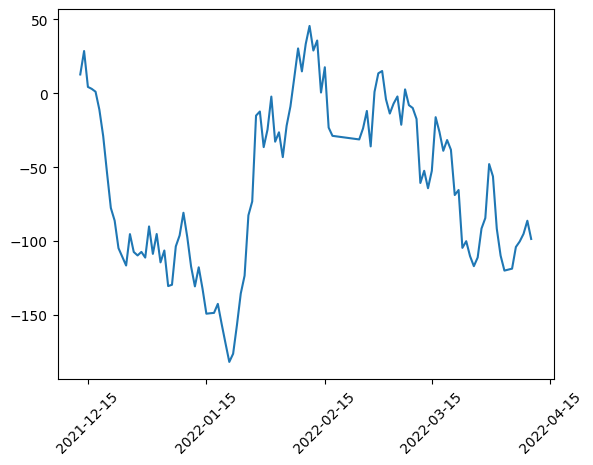

Profit: -98.55367680036898
Total Wagered: 8200
Profitability: -0.012018741073215728
******* CALCULATING SEASON **********
2022


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


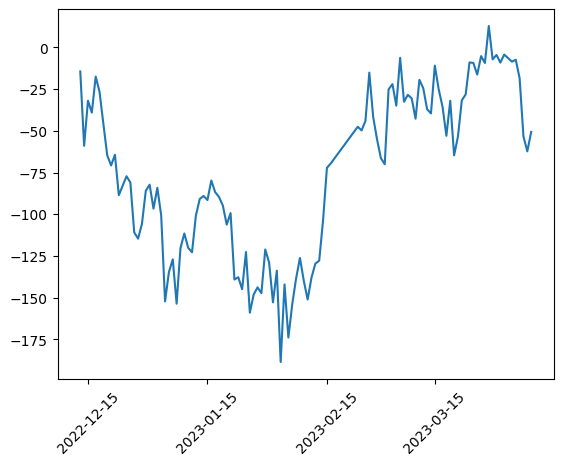

Profit: -50.647825262263055
Total Wagered: 8200
Profitability: -0.006176564056373544
******* CALCULATING SEASON **********
2023


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


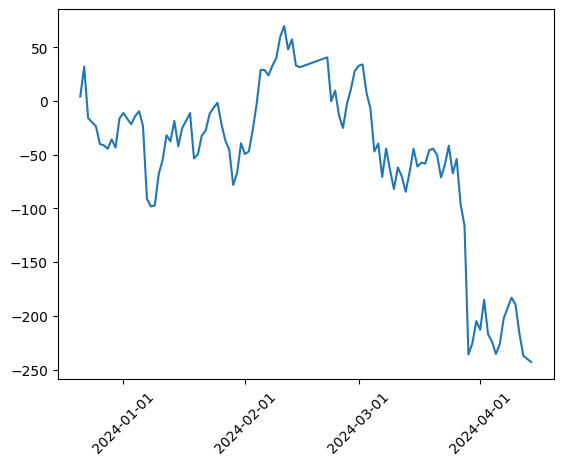

Profit: -242.99243604219996
Total Wagered: 8200
Profitability: -0.02963322390758536
******* CALCULATING SEASON **********
2024


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


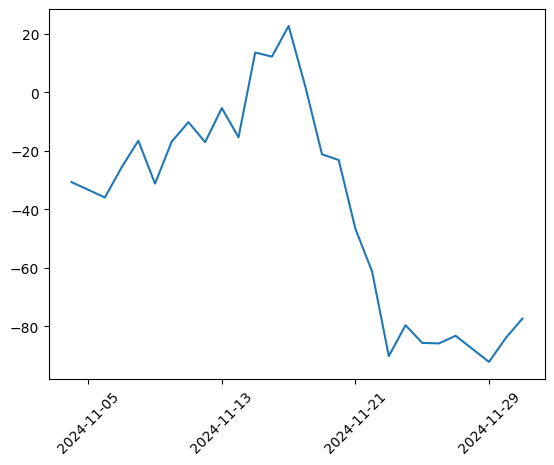

Profit: -77.40317862766547
Total Wagered: 2020
Profitability: -0.03831840526122053


In [15]:
for s in range(2020, 2025):
  print("******* CALCULATING SEASON **********")
  print(s)
  profit, total_wagers, profitability = calculate_moneyline_season_profitability(s)
  print(f"Profit: {profit}")
  print(f"Total Wagered: {total_wagers * 10 }")
  print(f"Profitability: {profitability}")

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
def calc_moneyline_predictions(row):
  home_odds = row["FANDUEL_HOME_ODDS"] or row["BETMGM_HOME_ODDS"] or row["CAESARS_HOME_ODDS"] or row["DRAFKINGS_HOME_ODDS"]
  if home_odds < 0 and row["HOME_TEAM_WINS"] == 1: # Correct home predictions
    return True
  elif home_odds > 0 and row["HOME_TEAM_WINS"] == 0: # Correct away predictions
    return True
  else: # Incorrect predictions
    return False

def calculate_moneyline_season_accuracy(s):
  season = nba_games_with_moneylines.loc[(nba_games_with_moneylines['SEASON'] == s)].sort_values(by="GAME_DATETIME")
  _, test_1, test_2 = np.array_split(season, 3)

  test = pd.concat([test_1, test_2])

  test["MONEYLINE_GUESS"] = test.apply(calc_moneyline_predictions, axis=1)
  return accuracy_score(test["HOME_TEAM_WINS"], test["MONEYLINE_GUESS"])

  # plt.plot(test["GAME_DATE_EST"].unique(), test.groupby("GAME_DATE_EST")["PROFIT"].sum().cumsum())
  # ax = plt.gca()
  # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45)
  # plt.locator_params(axis='x', nbins=5)
  # plt.show()
  # return (profit, len(test), profit / (len(test) * 10))

In [18]:
for s in range(2020, 2025):
  print("******* CALCULATING SEASON **********")
  print(s)
  print(calculate_moneyline_season_accuracy(s))

******* CALCULATING SEASON **********
2020
0.5791666666666667
******* CALCULATING SEASON **********
2021
0.6304878048780488
******* CALCULATING SEASON **********
2022
0.6573170731707317
******* CALCULATING SEASON **********
2023
0.6329268292682927
******* CALCULATING SEASON **********
2024
0.6237623762376238


/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/derek.gliwa/personal_dev/nba-data-scrapping/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is depr

## Conclusion
The model appears to perform better than just picking the moneyline favorite